In [16]:
from diags import Conventional
import numpy as np
import pandas as pd
from filter_df import filter_df
# from da_plots import base_plots, wind_base_plots
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from metpy.plots import USCOUNTIES

In [2]:
pd.set_option('display.max_columns', None) # so I can see all columns on the df

# Filter dataframe returned by PyGSI

## Read diag files

In [3]:
#temperature diag files
diag_t_ges_fp = '../example_data/diag_conv_t_ges.2024031812.nc4'
diag_t_anl_fp = '../example_data/diag_conv_t_anl.2024031812.nc4'

#wind diag files
diag_uv_ges_fp = '../example_data/diag_conv_uv_ges.2024031812.nc4'
diag_uv_anl_fp = '../example_data/diag_conv_uv_anl.2024031812.nc4'

In [4]:
#Temperature Diag file
# diag_ges = Conventional(diag_t_ges_fp)
# diag_anl = Conventional(diag_t_anl_fp)

#Wind Diag file
diag_ges = Conventional(diag_uv_ges_fp)
diag_anl = Conventional(diag_uv_anl_fp)

## Query data

In [5]:
df_ges = diag_ges.get_data()
df_anl = diag_anl.get_data()

In [6]:
df_anl['station_id'][0]

'IR272'

In [7]:
# for col in df_anl.columns:
#     # Check if all elements in the column are equal between _anl and _ges
#     if not (df_anl[col] == df_ges[col]).all():
#         print(f"Column '{col}' is different.")

## Testing PyGSI filter_obs function

### Set filter arguments

In [8]:
elv_range = (0,20)
p_range = (500,1000)
err_range = (0, 4)
station_ids = ['NLOYR3BA']

# Lat and lon ranges for colorado
co_lats = (37, 41)
co_lons = (360-109, 360-102) #to convert from deg west to deg east

In [9]:
#testing station_id filter
# df_anl_fil = filter_df(df_anl, station_ids=station_ids)
# df_ges_fil = filter_df(df_ges, station_ids=station_ids)

In [39]:
# wind examples
# df_anl_fil = filter_df(df_anl, obs_types= [287], hem='CONUS')
# df_ges_fil = filter_df(df_ges, obs_types= [287], hem='CONUS')
df_anl_fil = filter_df(df_anl, obs_types= [287], lat_range=co_lats, lon_range=co_lons)
df_ges_fil = filter_df(df_ges, obs_types= [287], lat_range=co_lats, lon_range=co_lons)

# temp examples
# df_anl_fil = filter_df(df_anl, obs_types= [187], hem='CONUS')
# df_ges_fil = filter_df(df_ges, obs_types= [187], hem='CONUS')
# df_anl_fil = filter_df(df_anl, obs_types= [187], lat_range=co_lats, lon_range=co_lons)
# df_ges_fil = filter_df(df_ges, obs_types= [187], lat_range=co_lats, lon_range=co_lons)
print(len(df_anl_fil))
print(len(df_ges_fil))

91
91


## Testing base plots

In [42]:
def wind_base_plots(df_anl, df_ges, metadata, **args):
    
    # check if the dfs passed are contain wind, which would have speed and direction
    if(metadata['Variable'] != 'uv'):
        print("Error: Use base_plots for non wind datasets")
        return None
    
    print('------------ Wind Data Assimilation Statistics and Plots ------------\n\n')
    
    # Get data arrays
    u_obs = df_ges['u_observation']
    v_obs = df_ges['v_observation']
    u_omf = df_ges['u_omf_adjusted']
    v_omf = df_ges['v_omf_adjusted']
    u_oma = df_anl['u_omf_adjusted']
    v_oma = df_anl['v_omf_adjusted']
    
    #* Create the bar plot by obs type showing proportional assimilated and total assimilated
    if(len(df_anl['observation_type'].unique()) > 1):
        assimilated_by_obs_plots(df_anl)
    else:
        prop_assimilated = df_anl['analysis_use_flag'].mean()
        ob_type = df_anl['observation_type'].iloc[0]
        print(f'Observation Type: {ob_type}\n\nProportion Assimilated: {prop_assimilated}\n')
    
    #*Plot histograms of obs, omf, and omb
    #get windspped or wind magnitude from two vectors
    mag_obs = np.sqrt( (u_obs**2) + (v_obs**2) )
    mag_omf = np.sqrt( (u_omf**2) + (v_omf**2) )
    mag_oma = np.sqrt( (u_oma**2) + (v_oma**2) )
        
    mag_omf = np.where((u_omf + v_omf) < 0, -mag_omf, mag_omf)
    mag_oma = np.where((u_oma + v_oma) < 0, -mag_oma, mag_oma)  
    
    # Create subplots
    fig, axes = plt.subplots(3, 3, figsize=(16, 5))

    #TODO Add customized labels based on variable type
    datasets = [(u_obs, 'U Observation'),
                 (u_omf, 'U OmF'),
                 (u_oma, 'U OmA'),
                 (v_obs, 'V Observation'),
                 (v_omf, 'V OmF'),
                 (v_oma, 'V OmA'),
                 (mag_obs, 'Wind Speed Observation'),
                 (mag_omf, 'Wind Speed OmF'),
                 (mag_oma, 'Wind Speed OmA')]

    axes = axes.flatten()
    for ax, (data, label) in zip(axes, datasets):
        # Get basic statistics
        n, mean, std, mx, mn = len(data), np.mean(data), np.std(data), np.max(data), np.min(data)
        print(f'{label} Statistics: \nn: {n}, mean: {mean}, std: {std}, max: {mx}, min: {mn}\n')
        
        # Make proper bin sizes using the equation max-min/sqrt(n). Then
        # extend the bin range to 4x the standard deviation
        binsize = (mx - mn) / np.sqrt(n)
        bins = np.arange(mean - (4 * std), mean + (4 * std), binsize)
        # Plot histogram
        ax.hist(data, bins=bins)
        # Add labels
        ax.set_xlabel(label)
        ax.set_ylabel('Count')
        ax.set_title(label + " Histogram", fontsize=14)

    # Add some more space between subplots
    plt.subplots_adjust(wspace=0.3, hspace=1)
    plt.show()
    
    
    # #* Create spatial plots of obs, omf, and oma
    
    # Define your datasets and metadata
    datasets = [
        ('Observations', df_ges, u_obs, v_obs, mag_obs),
        ('OmF', df_ges, u_omf, v_omf, mag_omf),
        ('OmA', df_anl, u_oma, v_oma, mag_oma)
    ]

    for title, df, u, v, mag in datasets:
        latlons = (df['latitude'], df['longitude'])
    
        area_size = (latlons[0].max() - latlons[0].min()) * (latlons[1].max() - latlons[1].min())
        
        plt.figure(figsize=(15, 20))
        
        # Add maps features
        ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=260))
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black')
        ax.add_feature(cfeature.STATES, edgecolor='black')
        if area_size < 50:
            ax.add_feature(USCOUNTIES.with_scale('500k'), linewidth=0.10, edgecolor='black')
        
        # Calculate dynamic scale based on the plot dimensions and reference arrow length
        x_range = latlons[1].max() - latlons[1].min()
        y_range = latlons[0].max() - latlons[0].min()
        
        # Normalize magnitude so the arrows are all the same size
        u_norm = u / np.abs(mag)
        v_norm = v / np.abs(mag)
        
        #2750 scale for CONUS
        cs = plt.quiver(latlons[1], latlons[0], u_norm, v_norm, mag, scale = 5, scale_units = 'inches', units = 'inches', width = 0.02,
                        cmap='plasma', transform=ccrs.PlateCarree())
        # Add a colorbar
        cb = plt.colorbar(cs, shrink=0.3, pad=.04, extend='both')
        cb.set_label('Wind Speed')
        # Add gridlines for latitude and longitude
        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0)
        gl.top_labels = False
        gl.right_labels = False
        plt.title(f"Wind Speed and Direction {title}")
        # Display the plot
        plt.show()

------------ Wind Data Assimilation Statistics and Plots ------------


Observation Type: 287

Proportion Assimilated: 0.791208803653717

U Observation Statistics: 
n: 91, mean: 1.1450549364089966, std: 2.0907578468322754, max: 7.099999904632568, min: -3.5

U OmF Statistics: 
n: 91, mean: 0.37752601504325867, std: 1.8200116157531738, max: 4.478912830352783, min: -2.440760850906372

U OmA Statistics: 
n: 91, mean: 0.0741645023226738, std: 0.5001339316368103, max: 1.508601427078247, min: -1.9756585359573364

V Observation Statistics: 
n: 91, mean: -0.0714285746216774, std: 1.6294864416122437, max: 3.799999952316284, min: -4.099999904632568

V OmF Statistics: 
n: 91, mean: 0.00226079230196774, std: 1.4278274774551392, max: 4.583501815795898, min: -2.4814577102661133

V OmA Statistics: 
n: 91, mean: -0.01565796509385109, std: 0.4116342067718506, max: 1.6907378435134888, min: -1.6363645792007446

Wind Speed Observation Statistics: 
n: 91, mean: 2.187013864517212, std: 1.8867207765579224, ma

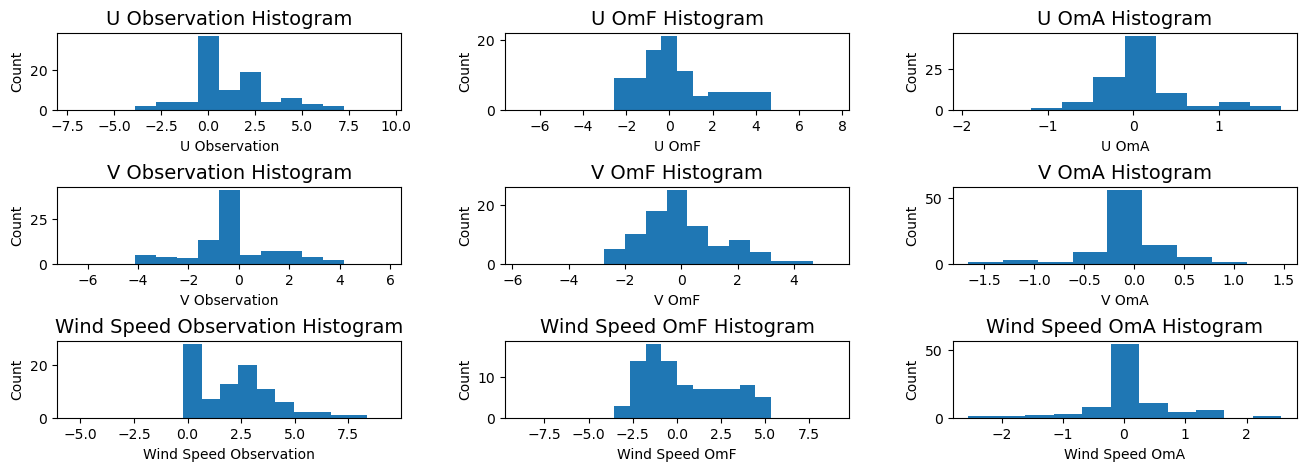

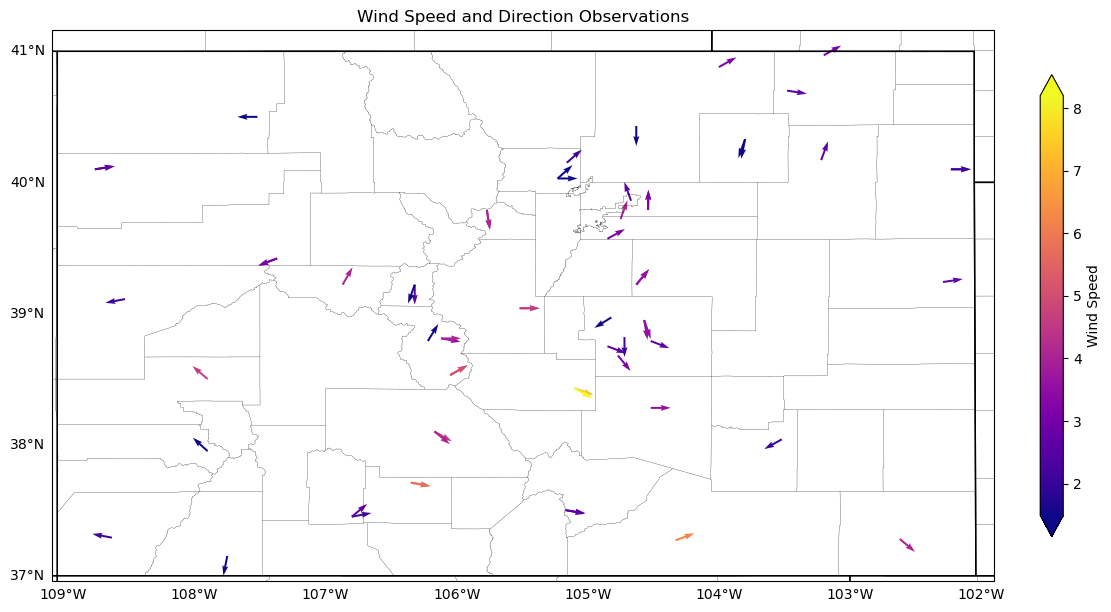

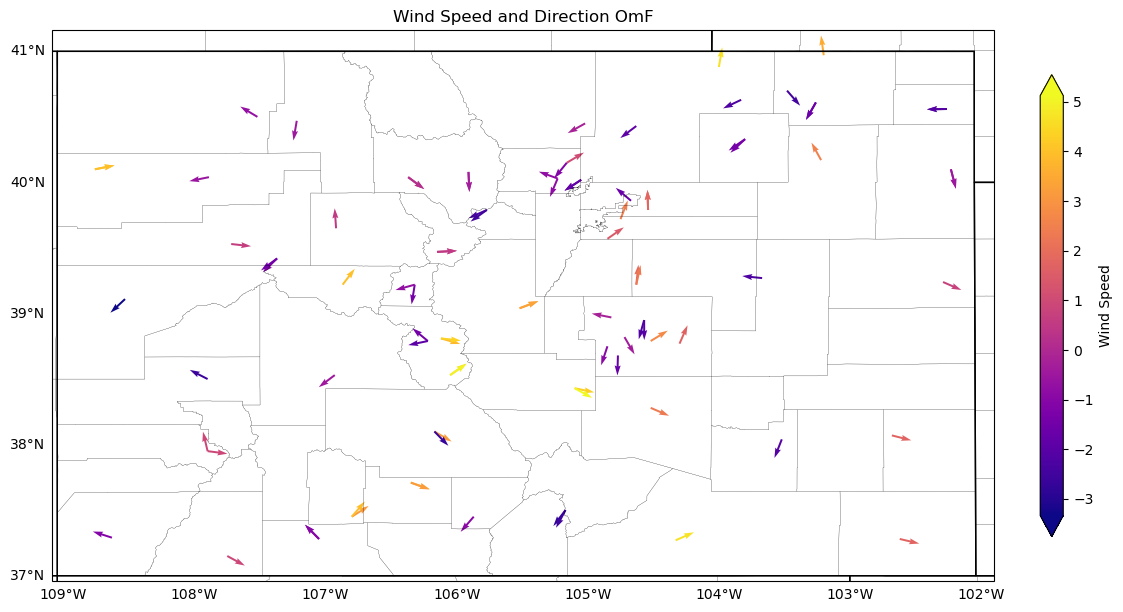

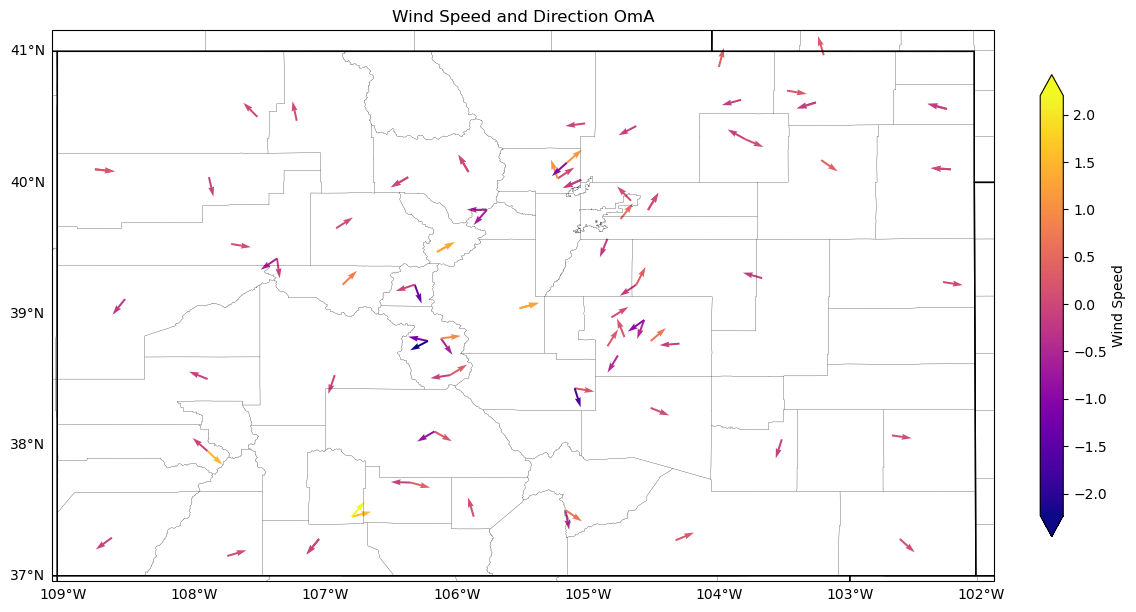

In [43]:
# base_plots(df_anl_fil, df_ges_fil, diag_ges.metadata)
wind_base_plots(df_anl_fil, df_ges_fil, diag_ges.metadata)